# Projet Lichess

_Traitements et données large échelle_

Zoé Marquis & Charlotte Kruzic

TODO : présenter les objectifs du projet, les différentes questions, les données utilisées


## Installation et importation des bibliothèques nécessaires

In [1]:
!pip install kagglehub

In [2]:
!pip install -q findspark

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import kagglehub

import findspark
from pyspark.sql import SparkSession

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz

In [5]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

## Préparation des données et de l'environnement

Chargement des données, analyse exploratoire et prétraitement des données.

### Chargement du fichier de données

In [6]:
path = kagglehub.dataset_download("noobiedatascientist/lichess-september-2020-data")
print("Chemin vers le fichier du dataset : ", path)

100%|██████████| 324M/324M [00:09<00:00, 36.2MB/s]

Extracting files...


Chemin vers le fichier du dataset :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3


In [7]:
files = os.listdir(path)
print("Fichiers du dataset : ", files)

Fichiers du dataset :  ['Sept_20_analysis.csv', 'Sept_20_analysis.RDS', 'Column information.txt']


In [8]:
filename = f"{path}/Sept_20_analysis.csv"
print("Nom du fichier : ", filename)

Nom du fichier :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3/Sept_20_analysis.csv


In [9]:
# voir le contenu du .txt
filename_txt = f"{path}/Column information.txt"
with open(filename_txt, 'r') as f:
    print(f.read())

GAME: Game ID (not from lichess.org)

BlackElo: Elo rating of the player with the black pieces

BlackRatingDiff: Rating change (gain/loss) after game conclusion for the player with the black pieces

Date: Date the game was played

ECO: Game opening (ECO notation)

Event: Event where the game was played

Opening: Game opening

Result: Result of the game

	1-0 -- White victory
	0-1 -- Black victory
	1/2-1/2 -- Draw
	* -- Undecided
	
Site: URL of the game

Termination: Way the game terminated

	Time forfeit -- One of the players ran out of time
	Normal -- Game terminated with check mate
	Rules infraction -- Game terminated due to rule breaking
	Abandoned -- Game was abandoned
	
TimeControl: Timecontrol in seconds that was used for the game (Starting time: Increment) 

UTCTime: Time the game was played

WhiteElo: Elo rating of the player with the white pieces

WhiteRatingDiff: Rating change (gain/loss) after game conclusion for the player with the white pieces

Black_elo_category: ELO cate

### Lancement de Spark

In [10]:
# Importation des éléments Spark
from pyspark.sql.functions import col, when, isnull, count, max as spark_max, countDistinct, row_number, split, concat_ws
from pyspark.sql.functions import col, when, floor
from pyspark.sql.window import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from collections import defaultdict

In [11]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [12]:
sc = spark.sparkContext
df_spark = spark.read.csv(filename, header=True, inferSchema=True)

In [13]:
df_spark.printSchema()

root
 |-- GAME: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- BlackRatingDiff: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Black_elo_category: string (nullable = true)
 |-- White_elo_category: string (nullable = true)
 |-- starting_time: integer (nullable = true)
 |-- increment: integer (nullable = true)
 |-- Game_type: string (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistak

In [14]:
# nombre lignes
df_spark.count()

3739909

In [15]:
df_spark.show(5)

+----+--------+---------------+----------+---+----------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_

### Préparation générale des données

Maintenant que les données sont chargées, nous y ajoutons les catégories ELO basées sur les plages données dans l'énoncé du projet.

En plus des 5 catégories définies dans l'énoncé, nous ajoutons "other lower bound" et "other upper bound" pour les valeurs ELO hors des plages.

#### Calcule des catégories

In [16]:
# Ajout des catégories ELO
# Catégorie ELO du joueur Noir
df_spark_plus = df_spark.withColumn("Black_ELO_category",
                              when((col("BlackElo") >= 1200) & (col("BlackElo") <= 1499), "occasional player")
                              .when((col("BlackElo") >= 1500) & (col("BlackElo") <= 1799), "good club player")
                              .when((col("BlackElo") >= 1800) & (col("BlackElo") <= 1999), "very good club player")
                              .when((col("BlackElo") >= 2000) & (col("BlackElo") <= 2399), "national and international level")
                              .when((col("BlackElo") >= 2400) & (col("BlackElo") <= 2800), "GMI, World Champions")
                              .when((col("BlackElo") < 1200), "other lower bound")
                              .otherwise("other upper bound")
                              )

# Catégorie ELO du joueur Blanc
df_spark_plus = df_spark_plus.withColumn("White_ELO_category",
                              when((col("WhiteElo") >= 1200) & (col("WhiteElo") <= 1499), "occasional player")
                              .when((col("WhiteElo") >= 1500) & (col("WhiteElo") <= 1799), "good club player")
                              .when((col("WhiteElo") >= 1800) & (col("WhiteElo") <= 1999), "very good club player")
                              .when((col("WhiteElo") >= 2000) & (col("WhiteElo") <= 2399), "national and international level")
                              .when((col("WhiteElo") >= 2400) & (col("WhiteElo") <= 2800), "GMI, World Champions")
                              .when((col("WhiteElo") < 1200), "other lower bound")
                              .otherwise("other upper bound")
                              )

# Catégorie ELO moyenne des 2 joueurs
df_spark_plus = df_spark_plus.withColumn("Avg_ELO_category", (col("BlackElo") + col("WhiteElo")) / 2)

df_spark_plus = df_spark_plus.withColumn("Avg_ELO_category",
                              when((col("Avg_ELO_category") >= 1200) & (col("Avg_ELO_category") <= 1499), "occasional player")
                              .when((col("Avg_ELO_category") >= 1500) & (col("Avg_ELO_category") <= 1799), "good club player")
                              .when((col("Avg_ELO_category") >= 1800) & (col("Avg_ELO_category") <= 1999), "very good club player")
                              .when((col("Avg_ELO_category") >= 2000) & (col("Avg_ELO_category") <= 2399), "national and international level")
                              .when((col("Avg_ELO_category") >= 2400) & (col("Avg_ELO_category") <= 2800), "GMI, World Champions")
                              .when((col("Avg_ELO_category") < 1200), "other lower bound")
                              .otherwise("other upper bound")
                              )

In [17]:
# vérifier combien de "other ..."
other_lower_bound_black = df_spark_plus.filter(col("Black_ELO_category") == "other lower bound").count()
other_lower_bound_white = df_spark_plus.filter(col("White_ELO_category") == "other lower bound").count()
other_upper_bound_black = df_spark_plus.filter(col("Black_ELO_category") == "other upper bound").count()
other_upper_bound_white = df_spark_plus.filter(col("White_ELO_category") == "other upper bound").count()
print(f"Nombre de parties avec other lower bound pour le joueur noir : {other_lower_bound_black}")
print(f"Nombre de parties avec other lower bound pour le joueur blanc : {other_lower_bound_white}")
print(f"Nombre de parties avec other upper bound pour le joueur noir : {other_upper_bound_black}")
print(f"Nombre de parties avec other upper bound pour le joueur blanc : {other_upper_bound_white}")

Nombre de parties avec other lower bound pour le joueur noir : 474566
Nombre de parties avec other lower bound pour le joueur blanc : 477997
Nombre de parties avec other upper bound pour le joueur noir : 1730
Nombre de parties avec other upper bound pour le joueur blanc : 1721


In [18]:
# répartition du nombre de parties pour avg
avg_other_lower_bound = df_spark_plus.filter(col("Avg_ELO_category") == "other lower bound").count()
avg_occasional_player = df_spark_plus.filter(col("Avg_ELO_category") == "occasional player").count()
avg_good_club_player = df_spark_plus.filter(col("Avg_ELO_category") == "good club player").count()
avg_very_good_club_player = df_spark_plus.filter(col("Avg_ELO_category") == "very good club player").count()
avg_national_international_level = df_spark_plus.filter(col("Avg_ELO_category") == "national and international level").count()
avg_GMI_World_Champions = df_spark_plus.filter(col("Avg_ELO_category") == "GMI, World Champions").count()
avg_other_upper_bound = df_spark_plus.filter(col("Avg_ELO_category") == "other upper bound").count()

# répartition du nombre de parties quand les 2 joueurs sont dans la même catégorie
same_player_other_lower_bound = df_spark_plus.filter((col("Black_ELO_category") == "other lower bound") & (col("White_ELO_category") == "other lower bound")).count()
same_player_occasional_player = df_spark_plus.filter((col("Black_ELO_category") == "occasional player") & (col("White_ELO_category") == "occasional player")).count()
same_player_good_club_player = df_spark_plus.filter((col("Black_ELO_category") == "good club player") & (col("White_ELO_category") == "good club player")).count()
same_player_very_good_club_player = df_spark_plus.filter((col("Black_ELO_category") == "very good club player") & (col("White_ELO_category") == "very good club player")).count()
same_player_national_international_level = df_spark_plus.filter((col("Black_ELO_category") == "national and international level") & (col("White_ELO_category") == "national and international level")).count()
same_player_GMI_World_Champions = df_spark_plus.filter((col("Black_ELO_category") == "GMI, World Champions") & (col("White_ELO_category") == "GMI, World Champions")).count()
same_player_other_upper_bound = df_spark_plus.filter((col("Black_ELO_category") == "other upper bound") & (col("White_ELO_category") == "other upper bound")).count()


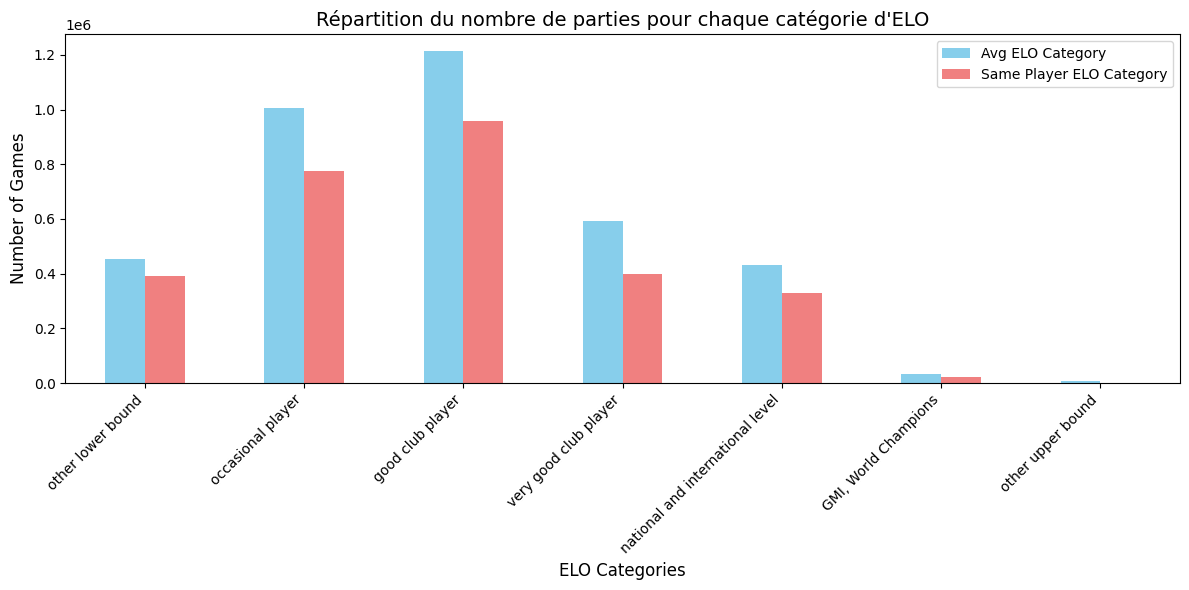

In [19]:
# Visualiser la répartition des catégories

categories = [
    "other lower bound", "occasional player", "good club player",
    "very good club player", "national and international level", "GMI, World Champions",
    "other upper bound"
]
avg_counts = [
    avg_other_lower_bound, avg_occasional_player, avg_good_club_player,
    avg_very_good_club_player, avg_national_international_level, avg_GMI_World_Champions,
    avg_other_upper_bound
]
same_player_counts = [
    same_player_other_lower_bound, same_player_occasional_player, same_player_good_club_player,
    same_player_very_good_club_player, same_player_national_international_level, same_player_GMI_World_Champions,
    same_player_other_upper_bound
]

df_counts = pd.DataFrame({
    'Category': categories,
    'Avg_ELO_category': avg_counts,
    'Same_Player_ELO_category': same_player_counts
})

plt.figure(figsize=(12, 6))
df_counts.set_index('Category')[['Avg_ELO_category', 'Same_Player_ELO_category']].plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'])
plt.xlabel('ELO Categories', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.title('Répartition du nombre de parties pour chaque catégorie d\'ELO', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(['Avg ELO Category', 'Same Player ELO Category'])
plt.tight_layout()
plt.show()

La répartition des données, bien que déséquilibrée entre les catégories, semble réaliste.

En effet, le nombre de parties avec des joueurs de niveaux intermédiaires est plus élevé, car ils représentent la plupart des joueurs actifs qui jouent régulièrement. Au contraire, le nombre de parties avec des joueurs ayant des niveaux extrêmes (faible ou élevé) est plus faible. Nous pouvons expliquer cela par le fait que les joueurs de bas niveau évoluent rapidement ou ne jouent pas beaucoup de parties, et les joueurs avec de hauts niveaux sont plus rares dû à la difficulté d'atteindre ces niveaux.

Ce déséquilibre naturel pourrait introduire un biais dans l'analyse, car certaines catégories sont sur/sous-représentées.

In [20]:
# Compter le nombre de moves pour chaque joueur (c'est White qui commence)
df_spark_plus = df_spark_plus.withColumn("white_moves",
                                         when(col("Total_moves") % 2 == 0, col("Total_moves") / 2)
                                         .otherwise(floor(col("Total_moves") / 2) + 1)
                                         )
df_spark_plus = df_spark_plus.withColumn("black_moves",
                                         when(col("Total_moves") % 2 == 0, col("Total_moves") / 2)
                                         .otherwise(floor(col("Total_moves") / 2))
                                         )

In [21]:
df_spark_plus.select("Total_moves", "white_moves", "black_moves").show(5)

+-----------+-----------+-----------+
|Total_moves|white_moves|black_moves|
+-----------+-----------+-----------+
|         66|       33.0|       33.0|
|         64|       32.0|       32.0|
|         70|       35.0|       35.0|
|         86|       43.0|       43.0|
|         71|       36.0|       35.0|
+-----------+-----------+-----------+
only showing top 5 rows



### Vérification des données

In [ ]:
# TODO : Mettre en forme cette partie, nettoyé et expliquer (ou tous virer lol)

In [ ]:
# TODO : ATTENTION A PRENDRE LES BONS DATASETS

In [ ]:
# TODO texte
# je capte pas pourquoi ECO ? genre ils mentionnent pas ECO dans l'énoncé donc on peut dire qu'on fait l'assertion d'utiliser que Opening ?
# ou alors on expliue un peu plus en amont pcq juste "alignés" c'est pas super clair

Les Opening et ECO coressepondent aux ouvertures, nous regardons s'ils sont alignés.

In [ ]:
# Nombre valeurs opening
print(f"Nombre de valeurs opening : {df_spark.select('Opening').distinct().count()}")
print(f"Nombre de valeurs ECO : {df_spark.select('ECO').distinct().count()}")

In [ ]:
#  Checker si les colonnes ECO et Opening sont toujours alignées
alignment_check_1 = df_spark.groupBy("ECO").agg(countDistinct("Opening").alias("Unique_Openings"))
misaligned_rows_1 = alignment_check_1.filter(col("Unique_Openings") > 1)

In [ ]:
# Afficher les résultats
if misaligned_rows_1.count() > 0:
    print("Il existe plusieurs Openings pour un code ECO.")
    misaligned_rows_1.show(5)
    print("Nombre de lignes : ", misaligned_rows_1.count())
else:
    print("Il existe un seul Opening pour un code ECO.")

In [ ]:
#  Checker si les colonnes ECO et Opening sont toujours alignées
alignment_check_2 = df_spark.groupBy("Opening").agg(countDistinct("ECO").alias("Unique_ECOs"))
misaligned_rows_2 = alignment_check_2.filter(col("Unique_ECOs") > 1)

In [ ]:
# Afficher les résultats
if misaligned_rows_2.count() > 0:
    print("Il existe plusieurs ECO pour un code Opening.")
    misaligned_rows_2.show(5)
    print("Nombre de lignes : ", misaligned_rows_2.count())
else:
    print("Il existe un seul ECO pour un code Opening.")

Beaucoup de Opening et ECO ne sont pas alignés, nous allons regarder si ce sont des erreurs.

In [ ]:
# Filtrer pour les ouvertures ayant plusieurs ECO
misaligned_rows_2 = alignment_check_2.filter(col("Unique_ECOs") > 1)
opening_eco_counts = df_spark.groupBy("Opening", "ECO").agg(count("*").alias("count"))
multiple_opening_eco_counts = misaligned_rows_2.join(opening_eco_counts, on="Opening", how="inner")
multiple_opening_eco_counts.orderBy("Opening", "count", ascending=False).show(truncate=False)


Cela ne semble pas être des erreurs, il n'y a pas de ECO ou Opening largement dominant, nous allons donc garder ces éléments comme cela et les considérer comme 2 colonnes distinctes.

In [ ]:
# TODO : Voir si on traite pour aligner ou si on fait juste avec Opening
# comme c'est fait actuellement

##### Gestion starting_time et increment

In [ ]:
# Même nombre null pour starting_time et increment, on vérifie que c'est aligné
df_spark.filter(col("starting_time").isNull() & col("increment").isNull()).count()

In [ ]:
# Afficher les type de game quand ces 2 colonnes sont NULL
df_spark.filter(col("starting_time").isNull() & col("increment").isNull()).select("Game_type").distinct().show()

In [ ]:
# Afficher les parties avec type de jeu Correspondence et starting_time ou increment non null
df_spark.filter((col("Game_type") == "Correspondence") & (col("starting_time").isNotNull() | col("increment").isNotNull())).show()

In [ ]:
# TODO : Les NULL sont normaux, on fait quoi ?

OK comme dans la doc

In [ ]:
# Vérifier si TimeControl correspond bien à starting_time+increment
# Extraire starting_time et increment à partir de TimeControl
df_spark_check = df_spark.withColumn(
    "starting_time_extracted",
    when(col("TimeControl") != "-", split(col("TimeControl"), "\+")[0].cast("int"))
    .otherwise(None))

df_spark_check = df_spark_check.withColumn(
    "increment_extracted",
    when(col("TimeControl") != "-", split(col("TimeControl"), "\+")[1].cast("int"))
    .otherwise(None))

# Recréer TimeControl avec les colonnes extraites
df_spark_check = df_spark_check.withColumn(
    "TimeControl_reconstructed",
    when(col("starting_time_extracted").isNull() & col("increment_extracted").isNull(), "-")
    .otherwise(concat_ws("+", col("starting_time_extracted"), col("increment_extracted")))
)

# Comparer TimeControl avec la recréation
df_spark_check = df_spark_check.withColumn(
    "is_matching",
    col("TimeControl") == col("TimeControl_reconstructed")
)

# Checker les résultats
df_spark_check.select("TimeControl", "starting_time", "increment", "starting_time_extracted", "increment_extracted", "TimeControl_reconstructed", "is_matching").show(5)
mismatch_count = df_spark_check.filter(col("is_matching") == False).count()
print(f"Nombre de désalignements : {mismatch_count}")

##### Gestion BlackRatingDiff et WhiteRatingDiff

In [ ]:
# Même nombre null pour starting_time et increment, on vérifie que c'est aligné
df_spark.filter(col("BlackRatingDiff").isNull() & col("WhiteRatingDiff").isNull()).count()

In [ ]:
# pourcentage null
prc_missed = round(df_spark.filter(col("BlackRatingDiff").isNull() | col("WhiteRatingDiff").isNull()).count()/df_spark.count()*100,2)
print(f"Pourcentage de NULL : {prc_missed}%")

In [ ]:
# TODO : Virer les lignes avec des NULL

## Réponses aux questions

### Question 1

In [22]:
# TODO rregarder au global inferior moves aussi ?
# Charlotte : "si c'est un commentaire pour moi, j'ai pas compris ce que ça veut dire mdrrr"
# pov : j'écris comme le théatre

*Q1: What is the rate of blunders, errors and inaccuracies per move, per level category and on Blitz type games (Blitz type is by far the most played on these online sites). A game has two players, whose ELOs are most likely different. You will be able to classify a game into a category, either by considering the average ELO of both players, or by considering only the games where both players are in the same category.*

**Hypothèse :** Les joueurs appartenant à des catégories plus expérimentées devraient présenter un taux d'erreurs plus faible.

In [23]:
# Filtre les parties avec le type de jeu Blitz
df_blitz = df_spark_plus.filter(col("Game_type") == "Blitz")
df_blitz.count()

1812120

#### Calcule des taux par partie

In [24]:
# Calcule taux de bourdes (blunders)
df_blitz = df_blitz.withColumn("Black_blunders_rate", col("Black_blunders") / col("black_moves")) \
                   .withColumn("White_blunders_rate", col("White_blunders") / col("white_moves"))

In [25]:
# Calcule taux d'erreurs (errors)
df_blitz = df_blitz.withColumn("Black_errors_rate", col("Black_mistakes") / col("black_moves")) \
                   .withColumn("White_errors_rate", col("White_mistakes") / col("white_moves"))

In [26]:
# Calcule taux d'imprecisions (inaccurcies)
df_blitz = df_blitz.withColumn("Black_inaccuracies_rate", col("Black_inaccuracies") / col("black_moves")) \
                   .withColumn("White_inaccuracies_rate", col("White_inaccuracies") / col("white_moves"))

#### Calcule des taux moyens par catégorie ELO (on considère le score ELO moyen des 2 joueurs)

In [27]:
df_avg_elo_summary = df_blitz.groupBy("Avg_ELO_category").agg(
    {"Black_blunders_rate": "avg", "White_blunders_rate": "avg",
     "Black_errors_rate": "avg", "White_errors_rate": "avg",
     "Black_inaccuracies_rate": "avg", "White_inaccuracies_rate": "avg"}
).withColumnRenamed("avg(Black_blunders_rate)", "Avg_Black_blunders_rate") \
 .withColumnRenamed("avg(White_blunders_rate)", "Avg_White_blunders_rate") \
 .withColumnRenamed("avg(Black_errors_rate)", "Avg_Black_errors_rate") \
 .withColumnRenamed("avg(White_errors_rate)", "Avg_White_errors_rate") \
 .withColumnRenamed("avg(Black_inaccuracies_rate)", "Avg_Black_inaccuracies_rate") \
 .withColumnRenamed("avg(White_inaccuracies_rate)", "Avg_White_inaccuracies_rate")

In [28]:
df_avg_elo_summary.show(5)

+--------------------+---------------------------+-----------------------+---------------------+---------------------+-----------------------+---------------------------+
|    Avg_ELO_category|Avg_White_inaccuracies_rate|Avg_White_blunders_rate|Avg_Black_errors_rate|Avg_White_errors_rate|Avg_Black_blunders_rate|Avg_Black_inaccuracies_rate|
+--------------------+---------------------------+-----------------------+---------------------+---------------------+-----------------------+---------------------------+
|   other upper bound|        0.08923646820987065|   0.053883314861216475|  0.09786062988127485|  0.09316825168156774|    0.05713253835834972|        0.09422886449242146|
|   other lower bound|        0.09123664425761414|    0.09505881705406403|  0.11316469323850303|  0.10800044716165165|    0.09865934120262021|        0.09602531148536161|
|GMI, World Champions|        0.07247529070529041|    0.03077546627182289|  0.06824732477795835|  0.06620118207859484|    0.03325752004748459|   

In [29]:
df_avg_elo_summary_pandas = df_avg_elo_summary.toPandas()

In [30]:
df_avg_elo_summary_pandas.isna().sum()

,0
Avg_ELO_category,0
Avg_White_inaccuracies_rate,0
Avg_White_blunders_rate,0
Avg_Black_errors_rate,0
Avg_White_errors_rate,0
Avg_Black_blunders_rate,0
Avg_Black_inaccuracies_rate,0


In [31]:
# Ordonner les catégories de joueurs
category_order = ["other lower bound", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions", "other upper bound"]
df_avg_elo_summary_pandas['Avg_ELO_category'] = pd.Categorical(df_avg_elo_summary_pandas['Avg_ELO_category'],  categories=category_order,  ordered=True)
df_avg_elo_summary_pandas = df_avg_elo_summary_pandas.sort_values('Avg_ELO_category')


categories = df_avg_elo_summary_pandas['Avg_ELO_category']
error_types = ['Blunders', 'Errors', 'Inaccuracies']

# Données par type d'erreur et catégorie
blunders = df_avg_elo_summary_pandas[['Avg_Black_blunders_rate', 'Avg_White_blunders_rate']].mean(axis=1)*100
mistakes = df_avg_elo_summary_pandas[['Avg_Black_errors_rate', 'Avg_White_errors_rate']].mean(axis=1)*100
inaccuracies = df_avg_elo_summary_pandas[['Avg_Black_inaccuracies_rate', 'Avg_White_inaccuracies_rate']].mean(axis=1)*100

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

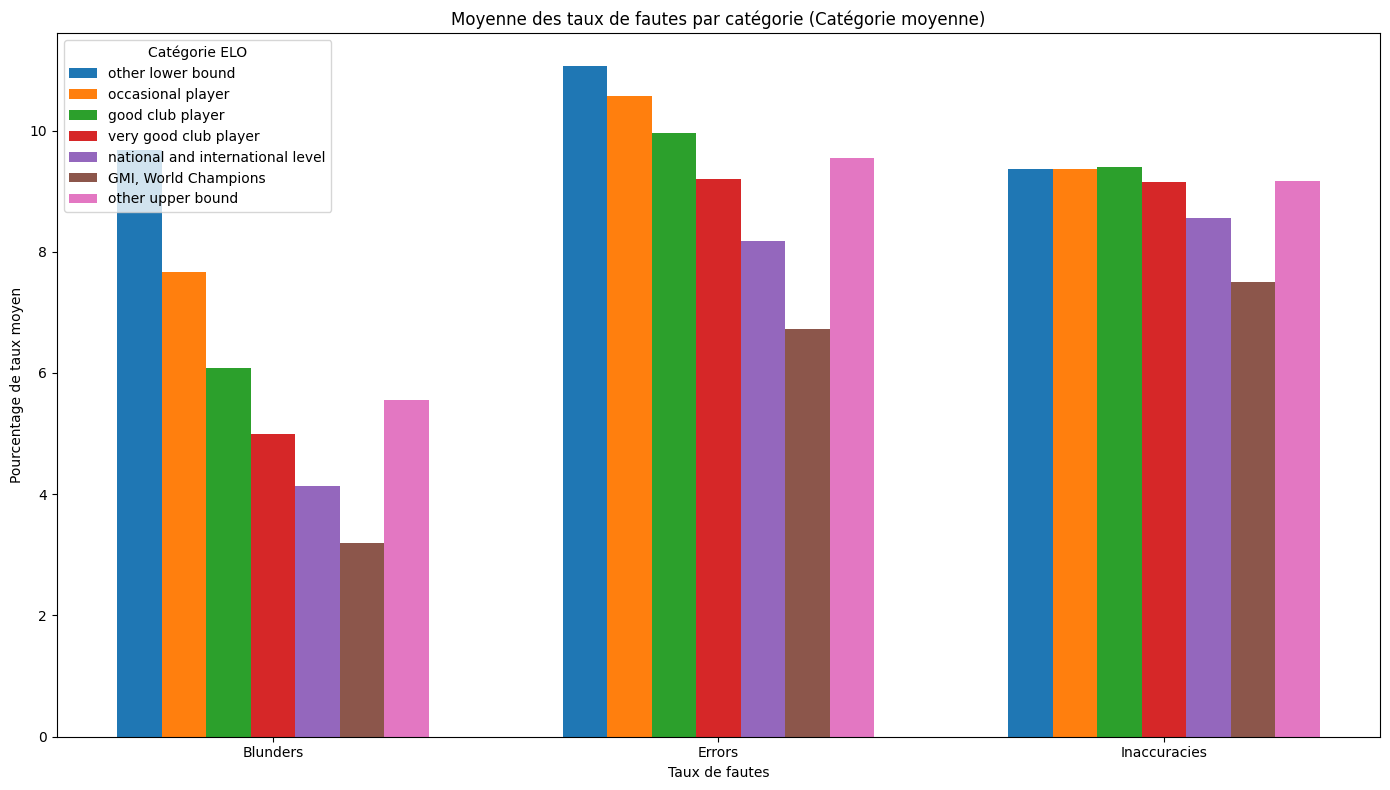

In [32]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.1

for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Taux de fautes')
plt.ylabel('Pourcentage de taux moyen')
plt.title('Moyenne des taux de fautes par catégorie (Catégorie moyenne)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

##### **Analyse des taux de blunders, errors et inaccuracies selon les catégories d'ELO**

Lorsque l'on analyse les taux de blunders, errors et inaccuracies en fonction des différentes catégories ELO, plusieurs tendances intéressantes émergent.  
En excluant la catégorie "Other Upper Bound", on observe une diminution progressive des taux de **bourdes** (blunders) à mesure que les catégories augmentent, avec une chute de moins en moins marquée. Cela suggère qu'il y a une amélioration du niveau des joueurs en fonction de leur catégorie ELO, bien qu'elle soit de moins en moins évidente pour les catégories les plus expérimentées.

Concernant les taux d'**erreurs** (errors), la diminution est relativement constante à travers les catégories, mais on remarque une chute plus importante lorsque l'on atteint les deux meilleures catégories ("National and International Level" et "GMI, World Champions"). Cela indique une amélioration notable dans la gestion des erreurs pour les joueurs de niveau supérieur.

Quant aux taux d'**imprécisions** (inaccuracies), la tendance reste assez stable pour les premières catégories, avec une diminution qui s'accélère à mesure que l'on approche des deux catégories les plus élevées. Cette tendance suggère également une amélioration du jeu des joueurs plus expérimentés.

En résumé, **les taux diminuent sensiblement à mesure que l'on progresse dans les catégories ELO**, avec une amélioration plus marquée pour les catégories "National and International Level" et "GMI, World Champions", ce qui reflète probablement un meilleur contrôle stratégique et une plus grande expérience des joueurs.

##### **Analyse de la catégorie "Other Upper Bound"**

Lorsque l'on considère la catégorie "Other Upper Bound", une tendance différente se dessine.  
Les taux de blunders, errors et inaccuracies semblent augmenter pour atteindre une **valeur entre celle des catégories "Good Club Player" et "Very Good Club Player"**.

Cette anomalie pourrait suggérer plusieurs pistes d'interprétation.  
Tout d'abord, il est possible que cette catégorie contienne des **données** qui ne sont **pas représentatives** du reste des catégories en raison d'un échantillon trop faible ou non nettoyé correctement.

Une autre hypothèse pourrait être que la **performance** des joueurs dans cette catégorie est **influencée** par la moyenne des ELO des deux joueurs, et non seulement par l'ELO individuel.  
Par exemple, un joueur avec un ELO élevé qui affronte un adversaire de niveau inférieur pourrait être amené à prendre plus de risques ou adopter des stratégies différentes, ce qui expliquerait certains résultats.  
De plus, il est possible qu'une partie classée dans la catégorie "Other upper bound" n'inclue qu'un seul joueur avec un ELO très élevé, ce qui fausse la moyenne des deux scores ELO et pourrait influencer l'analyse des performances.

#### Calcule des taux moyens par catégorie ELO (ici on considère seulement les parties où les joueurs sont dans la même catégorie)


In [33]:
df_same_category = df_blitz.filter(col("Black_ELO_category") == col("White_ELO_category"))

In [34]:
tot_blitz = df_blitz.count()
tot_same_cat = df_same_category.count()
print(f"Nombre de parties total : {tot_blitz}")
print(f"Nombre de parties avec 2 joueurs de la même catégorie : {tot_blitz}")
print(f"Pourcentage même catégorie : {tot_same_cat / tot_blitz * 100} %")

Nombre de parties total : 1812120
Nombre de parties avec 2 joueurs de la même catégorie : 1812120
Pourcentage même catégorie : 77.09219036266914 %


In [35]:
# TODO : expliquer qu'on introduit un biais (comme pour le avg ducoup enfaite...)
# poru avg dire qu'on devrait un peu étudier l'écrat type peut etre ?

In [36]:
df_same_category_summary = df_same_category.groupBy("Black_ELO_category").agg(
    {"Black_blunders_rate": "avg", "White_blunders_rate": "avg",
     "Black_errors_rate": "avg", "White_errors_rate": "avg",
     "Black_inaccuracies_rate": "avg", "White_inaccuracies_rate": "avg"}
).withColumnRenamed("avg(Black_blunders_rate)", "Avg_Black_blunders_rate") \
 .withColumnRenamed("avg(White_blunders_rate)", "Avg_White_blunders_rate") \
 .withColumnRenamed("avg(Black_errors_rate)", "Avg_Black_errors_rate") \
 .withColumnRenamed("avg(White_errors_rate)", "Avg_White_errors_rate") \
 .withColumnRenamed("avg(Black_inaccuracies_rate)", "Avg_Black_inaccuracies_rate") \
 .withColumnRenamed("avg(White_inaccuracies_rate)", "Avg_White_inaccuracies_rate")

In [37]:
df_same_category_summary_pandas = df_same_category_summary.toPandas()

In [38]:
# Ordonner les catégories de joueurs
category_order = ["other lower bound", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions", "other upper bound"]
df_same_category_summary_pandas['Black_ELO_category'] = pd.Categorical(df_same_category_summary_pandas['Black_ELO_category'],  categories=category_order,  ordered=True)
df_same_category_summary_pandas = df_same_category_summary_pandas.sort_values('Black_ELO_category')


categories = df_same_category_summary_pandas['Black_ELO_category']
error_types = ['Blunders', 'Errors', 'Inaccuracies']

# Données par type d'erreur et catégorie (moyenne) # TODO : Voir si on fait autrement
blunders = df_same_category_summary_pandas[['Avg_Black_blunders_rate', 'Avg_White_blunders_rate']].mean(axis=1)*100
mistakes = df_same_category_summary_pandas[['Avg_Black_errors_rate', 'Avg_White_errors_rate']].mean(axis=1)*100
inaccuracies = df_same_category_summary_pandas[['Avg_Black_inaccuracies_rate', 'Avg_White_inaccuracies_rate']].mean(axis=1)*100

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

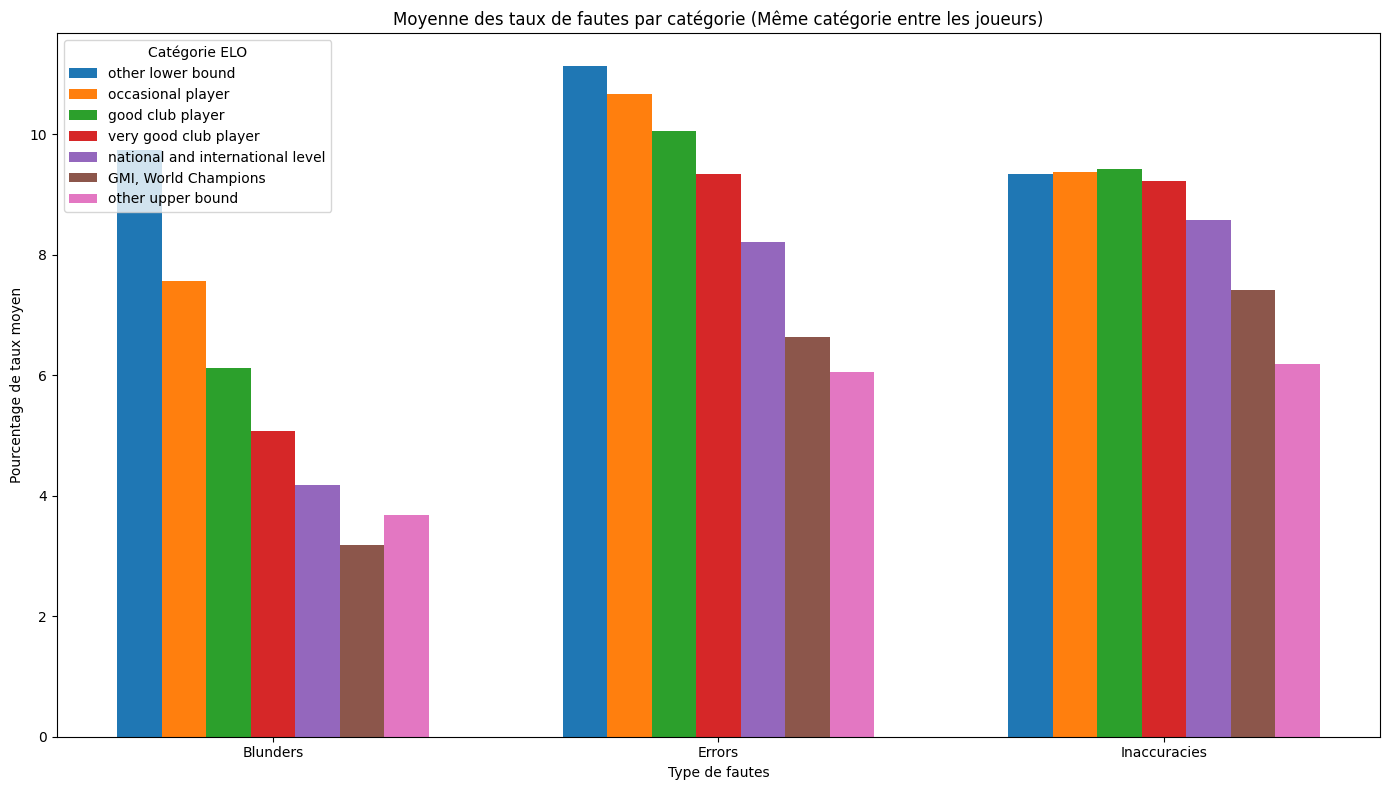

In [39]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.1
for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Type de fautes')
plt.ylabel('Pourcentage de taux moyen')
plt.title('Moyenne des taux de fautes par catégorie (Même catégorie entre les joueurs)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

Pour ces parties, où les deux joueurs appartiennent à la même catégorie, **les observations sont similaires** à celles faites pour la moyenne des ELO des joueurs.

Cependant, pour la catégorie **"Other upper bound"**, on ne constate **pas de réaugmentation** des erreurs et inexactitudes, ce qui confirme que la moyenne des ELO des deux joueurs influençait les résultats dans cette catégorie.

En revanche, une légère réaugmentation des blunders est observée entre les catégories "National and International level" et "GMI, World Champions".

#### Résultats globaux

Nous observons des **résultats similaires** entre les parties où les catégories sont basées sur la moyenne des ELO des deux joueurs et celles où les deux joueurs appartiennent à la même catégorie ELO. Nous voyons, en effet, que tous **les taux de fautes ont tendance à diminuer** à mesure que la catégorie ELO augmente.

Ce résultat est en accord avec l'hypothèse initiale.

### Question 2

Nous avons pu constater que certaines configurations n'étaient joués que quelques fois et toujours gagnés par les Blancs. Cela ajoute un biais, et ne permet pas de déterminer correctement quel opening permet le plus de gagner. On obtenait plus de 3800 White_win_probability=1.

Nous avons donc décidé de concerver seulement les configurations avec un nombre de parties jouées élevées.

TODO : Dire combien on garde finalement et pourquoi

##### Q2: Win probability depending on opening:

- Q2a: With which opening does White have the best chance to win, by level category (*) and by type of game (Blitz, Fast, Classic).

In [ ]:
# Calculer le nombre de parties pour chaque configuration
config_game_counts = df_spark_plus.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))
config_game_counts.orderBy("Total_games_count", ascending=False).show(5)

In [ ]:
# TODO : mais là tu prends plus en compte les ECO ?? tu prends que Opening ?
# tu veux pas faire une config ou tu groupes par Opening ECO category et game type ?

In [ ]:
# Nombre total de configurations uniques
print(f"Nombre total de configurations possibles : {config_game_counts.count()}")

In [ ]:
# Filtrer les configurations avec plus de 1000 parties jouées
# TODO : Voir si on adapte le nombre de parties (autre chose que 1000)
filtered_configurations = config_game_counts.filter(col("Total_games_count") > 1000)
filtered_configurations.orderBy("Total_games_count", ascending=False).show(5)
print(f"Nombre de configurations avec plus de 1000 parties jouées : {filtered_configurations.count()}")

In [ ]:
# TODO ZOE je pense qu'on enleve le > 1000 car on perd trop de catégories

In [ ]:
# On utilise que les configurations avec plus de 1000 parties
filtered_df = df_spark_plus.join( filtered_configurations.select("Opening", "White_ELO_category", "Game_type"), on=["Opening", "White_ELO_category", "Game_type"], how="inner")


In [ ]:
# quels sont les différentes valeurs de Game_type ?
filtered_df.select("Game_type").distinct().show()

L'énoncé précise "by type of game (Blitz, Fast, Classic)" mais on voit bien ici que c'est Blitz, Rapid et Classical.

In [ ]:
# comment sont explicités les différentes fin de partie ?
filtered_df.select("Result").distinct().show()

1-0 -- White victory  
0-1 -- Black victory  
(vérifier dans la documentation)

In [ ]:
# Récupération des parties voulues (blancs gagnes +  type de jeux Blitz, Fast, Classic)
df_white_wins = filtered_df.filter((col("Result") == "1-0") & (col("Game_type").isin(["Blitz", "Rapid", "Classical"])))
df_total_games = filtered_df.filter(col("Game_type").isin(["Blitz", "Rapid", "Classical"]))

In [ ]:
# Pour chaque ouverture, catégorie et type de jeu on calcule le nombre de victoires des blancs
df_white_wins_groupby = df_white_wins.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("White_win_count"))

# Pareil mais on calcule le total de parties jouées
df_total_games_groupby = df_total_games.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))

In [ ]:
df_white_wins_groupby.show(5)

In [ ]:
df_total_games_groupby.show(5)

In [ ]:
# Calcule de la probabilité de gagner en fonction de l'ouverture
df_opening_stats = df_white_wins_groupby.join(df_total_games_groupby, on=["Opening", "White_ELO_category", "Game_type"])
df_opening_stats = df_opening_stats.withColumn("White_win_probability", col("White_win_count") / col("Total_games_count"))

In [ ]:
df_opening_stats.show(5)

In [ ]:
df_opening_stats.count()

In [ ]:
# y a t il toutes les combinaisons de catégorie / type de partie ?
df_opening_stats.groupBy("White_ELO_category", "Game_type").count().orderBy("count", ascending=False).show(truncate=False)

TODO : faut puet etre qu'on regle autrement ou alors on commente sur le fait qu'on a pas Classical pour toutes les catégories etc


On voit que pour certaines combinaisons il y a peu d'Openings différent

In [ ]:
df_spark_plus.groupBy("White_ELO_category", "Game_type").count().orderBy("count", ascending=False).show(truncate=False)

TODO : on voit ue de base y a pas autant de Classical que le reste... toutes les combinaisons pas possibles

In [ ]:
# Récupération du meilleur opening pour chaque catégorie de joueur et type de partie
window_spec = Window.partitionBy("White_ELO_category", "Game_type").orderBy(col("White_win_probability").desc())
best_openings = df_opening_stats.withColumn("rank", row_number().over(window_spec))
best_openings = best_openings.filter(col("rank") == 1).select("White_ELO_category", "Game_type", "Opening", "White_win_probability")

In [ ]:
best_openings.orderBy("White_ELO_category", "Game_type").show(truncate=False)

In [ ]:
best_openings_pandas = best_openings.toPandas()

In [ ]:
best_openings_pandas["GameType_Category"] = (best_openings_pandas["Game_type"] + " | " + best_openings_pandas["White_ELO_category"])

# Table pivot pour voir le meilleur opening pour chaque configuration
pivot_table = best_openings_pandas.pivot_table(
    index="GameType_Category",
    columns="Opening",
    values="White_win_probability"
)

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Meilleure opening (plus grande probabilité de victoire) des Blancs pour une catégorie et un Game Type")
plt.xlabel("Opening")
plt.ylabel("Type de jeu et Catégorie ELO")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# TODO : Voir comment on conclut ici en fonction de combien de parties min on utilise

# On voit que King's ... permet de gagner dans plusieurs conf

- Q2b: same question with black. You don't need to write again the same but only the results with black.

In [ ]:
# TODO : Copier ce qu'il y a dans Q2a en remplacant White_ELO_category par Black_ELO_category
# A faire quand on aura décidé comment on fait

In [ ]:
df_black_wins = filtered_df.filter((col("Result") == "0-1") & (col("Game_type").isin(["Blitz", "Rapid", "Classical"])))
df_total_games = filtered_df.filter(col("Game_type").isin(["Blitz", "Rapid", "Classical"]))

In [ ]:
df_black_wins_groupby = df_black_wins.groupBy("Opening", "Black_ELO_category", "Game_type").agg(count("*").alias("Black_win_count"))
df_total_games_groupby = df_total_games.groupBy("Opening", "Black_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))

In [ ]:
df_opening_stats = df_black_wins_groupby.join(df_total_games_groupby, on=["Opening", "Black_ELO_category", "Game_type"])
df_opening_stats = df_opening_stats.withColumn("Black_win_probability", col("Black_win_count") / col("Total_games_count"))

In [ ]:
window_spec = Window.partitionBy("Black_ELO_category", "Game_type").orderBy(col("Black_win_probability").desc())
best_openings = df_opening_stats.withColumn("rank", row_number().over(window_spec))
best_openings = best_openings.filter(col("rank") == 1).select("Black_ELO_category", "Game_type", "Opening", "Black_win_probability")
best_openings.orderBy("Black_ELO_category", "Game_type").show(truncate=False)

In [ ]:
best_openings_pandas = best_openings.toPandas()

In [ ]:
best_openings_pandas["GameType_Category"] = (best_openings_pandas["Game_type"] + " | " + best_openings_pandas["Black_ELO_category"])
pivot_table = best_openings_pandas.pivot_table(
    index="GameType_Category",
    columns="Opening",
    values="Black_win_probability"
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Probabilités de victoire des Noirs par Opening et Configuration")
plt.xlabel("Opening")

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Meilleure opening (plus grande probabilité de victoire) des Noirs pour une catégorie et un Game Type")
plt.xlabel("Opening")
plt.ylabel("Type de jeu et Catégorie ELO")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# TODO : iuci faut peut etre dire que opening c'est le coup fait par le blanc (à moins que ce soit plusieurs enchainement s?)

In [ ]:
# TODO : ici on peut regarder si on retrouve les memes choses entre noir et blanc

### Question 3

*Q3: (difficult). Does a line of data in the file predict the outcome of the game (column Result), and with what
probability? In other words, can any of the variables, such as the number of errors (mistakes, blunders, inacurracies,
ts_blunders), the difference in ELO between the two players, etc., explain the outcome (win/loss)? You are free to
define explain as you wish. It can be a correlation, linear or not, or any other relationship that allows this prediction.  
Note that the ELO is itself computed from a probability (normal distribution) of victory depending on the difference
in ELO of the two players. For instance, for a difference of 100 ELO points, the higher ranked player is expected to
win with probability 0.64. For a 200 points difference, it is 0.76.  
As we have more data than the ELO difference, your prediction should be more accurate than that.*

In [ ]:
# TODO zoe : mes idées pour cette partie c'est de faire :

# préparer les données -> result à encoder
# différence de ELO blanc noir et / ou noir blanc
# on prend en compte blunders, mistakes, inaccuracies (la même avec les ts_)
# normaliser et encoder
# MLLIB -> vecteur
# train et test séparation
# construire modèle de régression (logistique ?) ou arbre (genre random forest ou xgboost ?)
# évaluer : MulticlassClassificationEvaluator
# interpréter : Comparez la performance du modèle à celle prédite uniquement par la différence d'ELO (probabilités théoriques).
# analyse les coefficients (dans le cas de la régression logistique) : importance de chaque variable.


# en fait ils veulent qu'on explique... y a pas moyen de faire un truc avec explicabilité ?

#### Observation des données

In [ ]:
df_spark.show(5)

#### Gestion valeurs NULL

In [ ]:
# Calcule valeurs null par colonnes
null_counts = df_spark.select(
    *[
        count(when(col(c).isNull(), c)).alias(c)
        for c in df_spark.columns
    ]
)

null_counts.show()

In [ ]:
# TODO CHARLOTTE lis : tu t'es trop pris la tete mdrrr

# BlackRatingDiff: Rating change (gain/loss) after game conclusion for the player with the black pieces
# WhiteRatingDiff idem
# genre pour la prédiction c'est pas ouf on pourrait ne pas les prendre pcq c'est plutot une conséquence de qui a gagné ?
# pour le starting time bah osef en vrai c'est pareil ce serait bien de pas prendre en compte
# ducoup on pourrait juste drop ? on fait l'assumption au début (ils disent dans l'énonce on peut faire des assumptions)
# increment à null c'est pcq c'est des parties par correspondance (pas en temps réel)

# idem pour Date que pour starting time  ducoup
# et je pense iden pour Time Control et UTC Time ducoup (on veut pa que ce soit ça qui influence...)

# on peut suppr le GAME aussi (l'id)

# on peut aussi suppr l'URL (métadonnée)

# Event ? a t on vraiment besoin ? c'est plus une métadonnée non ? -> c'est pas une donnée sur la parie en tant que telle

Valeurs null dans les colonnes :
- BlackRatingDiff
- WhiteRatingDiff
- starting_time
- increment

#### Conservation des colonnes utiles

In [ ]:
# Colonnes inutiles
# - GAME : un ID, Date, Site, UTCTime, TimeControl

# TODO ZOE : je suis d'accord mdrrr mais faudrait peut etre le faire avant quand on drop tout et pourquoi on se permet de le drop

In [ ]:
# Suppression colonnes inutiles
columns_to_drop = ["GAME", "Date", "Site", "UTCTime","TimeControl"]
df_spark_cleaned = df_spark.drop(*columns_to_drop)

In [ ]:
# Observation des valeurs dans la colonne Result
result_counts = df_spark_cleaned.groupBy("Result").count()
result_counts.orderBy("count", ascending=False).show()

In [ ]:
# TODO : Très peu de indéfini + prédit rien donc peut etre supprimer,
# revoir en fonction des résultats obtenus
df_spark_cleaned = df_spark_cleaned.filter(col("Result") != "*")

#### Gestion des données non numérique

In [ ]:
# Observation des types des colonnes pour savoir comment les traiter
schema = df_spark_cleaned.schema
columns_by_type = defaultdict(list)

for field in schema:
    columns_by_type[str(field.dataType)].append(field.name)

for data_type, columns in columns_by_type.items():
    print(f"Type: {data_type}")
    print(f"Columns: {columns}\n")

In [ ]:
# Afficher les valeurs pour les colonnes non numériques
columns_to_check = [
    'ECO', 'Event', 'Opening', 'Result', 'Termination',
    'Black_elo_category', 'White_elo_category', 'Game_type'
]

for column in columns_to_check:
    print(f"Valeurs possibles pour la colonne '{column}':")
    df_spark_cleaned.select(column).distinct().show(truncate=False)


In [ ]:
# Extraire le type d'evenement
df_spark_cleaned = df_spark_cleaned.withColumn("Event_type", split(col("Event"), "https://")[0])
df_spark_cleaned.select("Event", "Event_type").show(5)

In [ ]:
# Afficher les Event_type différents
df_spark_cleaned.select("Event_type").distinct().show(truncate=False)

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import when

In [ ]:
# Gérer les différentes colonnes non-numériques

# Beaucoup de valeurs : ECO et Opening
indexer_eco = StringIndexer(inputCol="ECO", outputCol="ECO_index")
indexer_opening = StringIndexer(inputCol="Opening", outputCol="Opening_index")

df_spark_cleaned = indexer_eco.fit(df_spark_cleaned).transform(df_spark_cleaned)
df_spark_cleaned = indexer_opening.fit(df_spark_cleaned).transform(df_spark_cleaned)

# Peu de valeurs : Termination, Black_elo_category, White_elo_category, Game_type, Event_type
# TODO : Voir si on fait One Hot mais apres c'est trop lourd pour convertir en df Pandas
columns_to_encode = ["Termination", "Black_elo_category", "White_elo_category", "Game_type", "Event_type"]
# TODO CHARLOTTE LIS -> on garde pas leur elo category mais celles que nous on a créé plutot ce serait mieux
# je pense on dégage le event type
# on one hot encode trkl

for column in columns_to_encode:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    df_spark_cleaned = indexer.fit(df_spark_cleaned).transform(df_spark_cleaned)

# Colonne à retrouver : Result
df_spark_cleaned = df_spark_cleaned.withColumn(
    "Result_encoded",
    when(col("Result") == "1-0", 1)
    .when(col("Result") == "0-1", 0)
    .when(col("Result") == "1/2-1/2", -1)
    .otherwise(None) # TODO le * on en fait quoi ?
)

In [ ]:
df_spark_cleaned.printSchema()

In [ ]:
df_spark_cleaned.show(5)

In [ ]:
# Supprimer colonnes string remplacées si dessus
df_spark_cleaned_num = df_spark_cleaned.drop('ECO','Site','Opening','Termination','Black_elo_category','White_elo_category','Game_type','Result','Event','Event_type')

In [ ]:
# TODO ZOE j'ai po compris

In [ ]:
df_spark_cleaned_num.show(5)

In [ ]:
df_spark_cleaned_num.printSchema()

#### Matrice de corrélation

In [ ]:
# Calcule de la corrélation dans spark car pas assez de mémoire

In [ ]:
# TODO : Gérer les valeurs NULL au dessus avant de pouvoir faire la suite

#### PCA

#### Modèle

### Questions supplémentaires

## Idées questions supplémentaires

- influence of time spent per move on errors
  - existe t il une corrélation entre le temps moyen par coup et le nombre d'erreurs ?
  - analyse par niveau et type de jeu

- distribtion of drawn games by opening and level
  - quelles ouvertures ont une probabilité plus élevée de conduire à une partie nulle ?
  - analyse des taux de parties nulles en fonciton de l'ouverture et des catégories ELO

- impact of ELO difference on game length
  - les parties avec une grande différence d'ELO durent-elles moins longtemps (en nombre de coups) ?

- most common mistakes by level
  - quels types d'erreurs sont les plus fréquents selon les catégories ELO ?
  - comparaison entre joueurs de niveau débutant et expert

- optimal strategy for specific openings
  - pour une ouverture donnée (à sélectionner manuellement), quelle est la stratégie optiale selon le niveau des joueurs ?